In [2]:
import pandas as pd

In [6]:
recipes_df = pd.read_csv(r"C:\Users\broth\Documents\GitHub\team-no-food-waste-for-you\data\trader_joes_recipes.csv")  

In [7]:
products_df = pd.read_csv(r"C:\Users\broth\Documents\GitHub\team-no-food-waste-for-you\data\trader_joes_products_v2.csv")  
product_names = products_df['product_name'].tolist()

In [8]:
import ast

recipes_df['ingredients_list'] = recipes_df['ingredients'].apply(ast.literal_eval)

In [9]:
recipes_df['ingredients_list']

0      [4 tablespoons TJ’s Salted Butter, 2 tablespoo...
1      [1 TJ’s Pork Tenderloin, TJ’s Mushroom & Compa...
2      [2 tablespoons TJ’s Avocado Oil, 1 package TJ’...
3      [1 large TJ’s Yellow Potato, thinly sliced usi...
4      [1 package TJ’s Organic Crescent Rolls, ¼ bloc...
                             ...                        
550    [1 stick TJ's Unsalted Butter, softened, 2 tab...
551    [1 package (12 oz.) TJ's Cut Butternut Squash,...
552    [1 tablespoon TJ's Olive oil, 1/2 package TJ's...
553    [1 package (8 waffles) TJ's Frozen Toaster Waf...
554    [1 package TJ's Mini Pearl Grape Tomatoes, 1 p...
Name: ingredients_list, Length: 555, dtype: object

In [ ]:
import re

STOPWORDS = {'tjs', 'tj', 'organic', 'fresh', 'optional', 'favorite', "tj's"}

def normalize_text(text):
    text = text.lower().strip()
    text = re.sub(r'^\d+\s*/?\d*\s*', '', text)  # remove leading numbers/fractions
    units = [
        'tablespoon', 'tablespoons', 'tbsp', 'teaspoon', 'tsp', 'cup', 'cups',
        'package', 'stick', 'oz', 'ounce', 'ounces', 'pound', 'lb', 'large', 'small', 'pieces', 'jars',
    ]
    for unit in units:
        text = re.sub(r'\b' + unit + r'\b', '', text)

    text = re.sub(r'[^a-z0-9\s\'&]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # Remove stopwords like "tj's", "organic", etc.
    tokens = [word for word in text.split() if word not in STOPWORDS]
    return ' '.join(tokens).strip()

In [ ]:
import re
import pandas as pd

# --- 1️⃣ Function to split ingredient into (base, preparation) ---
def split_ingredient_details(ingredient):
    """
    Splits an ingredient string into (base_ingredient, preparation).
    Example:
        "1 TJ’s Lemon, sliced into wedges"
        -> ("1 TJ’s Lemon", "sliced into wedges")
    """
    # Default values
    base = ingredient
    prep = ""

    # Keywords that usually signal preparation
    prep_keywords = [
        'chopped', 'diced', 'minced', 'peeled', 'sliced', 'grated',
        'for garnish', 'to taste', 'melted', 'cooked', 'softened',
        'crumbled', 'plus', 'and', 'wedges', 'juice', 'zest'
    ]

    # Split on comma/semicolon/parenthesis
    parts = re.split(r'[,(;]', ingredient, maxsplit=1)
    if len(parts) > 1:
        possible_prep = parts[1].lower()
        if any(kw in possible_prep for kw in prep_keywords):
            base = parts[0].strip()
            prep = parts[1].strip(') ').strip()

    return base, prep


# --- 2️⃣ Functions to apply to list columns ---
def extract_base_ingredients(ing_list):
    return [split_ingredient_details(i)[0] for i in ing_list]

def extract_preparations(ing_list):
    return [split_ingredient_details(i)[1] for i in ing_list]


# --- 3️⃣ Apply to your DataFrame ---
recipes_df['base_ingredients'] = recipes_df['ingredients_list'].apply(extract_base_ingredients)
recipes_df['preparation'] = recipes_df['ingredients_list'].apply(extract_preparations)


# --- 4️⃣ Normalize the base ingredients (use your existing normalize_text) ---
import re

import re

def normalize_text(text):
    STOPWORDS = {
        'tjs',"tj's", 'tj', 'trader', 'joes', 'organic', 'fresh',
        'optional', 'favorite', 'your', 'own', 'fresh',
    }
    
    text = text.lower().strip()
    
    # --- 1️⃣ Remove anything before "TJ's" or "Trader Joe's" ---
    text = re.sub(r".*?(tj[’']s|trader\s*joe[’']s)\s*", "", text)
    
    # --- 2️⃣ Remove anything after the first comma ---
    if ',' in text:
        text = text.split(',', 1)[0].strip()
    
    # --- 3️⃣ Remove any units or measurements that might remain ---
    units = [
        'tablespoon', 'tablespoons', 'tbsp', 'teaspoon', 'tsp',
        'cup', 'cups', 'package', 'pkg', 'stick', 'oz', 'ounce',
        'ounces', 'pound', 'lb', 'large', 'small', 'bag', 'box', 'container'
    ]
    for unit in units:
        text = re.sub(r'\b' + unit + r'\b', '', text)
    
    # --- 4️⃣ Remove punctuation and normalize spaces ---
    text = re.sub(r'[^a-z0-9\s\'&]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # --- 5️⃣ Remove stray "s" left from "TJ’s" clipping ---
    text = re.sub(r"^s\s+", "", text)
    
    # --- 6️⃣ Remove stopwords ---
    tokens = [word for word in text.split() if word not in STOPWORDS]
    text = ' '.join(tokens).strip()
    
    return text




recipes_df['normalized_ingredients'] = recipes_df['base_ingredients'].apply(
    lambda ing_list: [normalize_text(i) for i in ing_list]
)


In [ ]:
from rapidfuzz import process, fuzz

def fuzzy_match_with_score(ingredient_norm, threshold=75):
    if not ingredient_norm:
        return None, 0
    match, score, _ = process.extractOne(
        ingredient_norm,
        normalized_products,
        scorer=fuzz.token_set_ratio
    )
    return (match, score) if score >= threshold else (None, score)

def fuzzy_candidates(ingredient, candidates, limit=5, scorer=fuzz.token_set_ratio):
    """
    Returns a list of top N candidate matches with scores.
    """
    ingredient_norm = ingredient.lower().strip()
    matches = process.extract(
        ingredient_norm,
        candidates,
        scorer=scorer,
        limit=limit
    )
    return matches

def fuzzy_best_length(ingredient, candidates, limit=5, scorer=fuzz.token_set_ratio):
    matches = fuzzy_candidates(ingredient, candidates, limit=limit, scorer=scorer)
    # sort by score first, then by closest length
    ingredient_len = len(ingredient)
    matches.sort(key=lambda x: (-x[1], abs(len(x[0]) - ingredient_len)))
    return matches

def fuzzy_match_best(ingredient, candidates):
    matches = fuzzy_best_length(ingredient, candidates)
    return matches[0][0] if matches else None 

In [ ]:
# recipes_df['matched_data'] = recipes_df['normalized_ingredients'].apply(
#     lambda ing_list: [fuzzy_match_with_score(i) for i in ing_list]
# )

recipes_df['fuzzy_candidates'] = recipes_df['normalized_ingredients'].apply(
    lambda ing_list: [
        fuzzy_best_length(i, normalized_products, limit=5) for i in ing_list
    ]
)



In [ ]:
comparison_rows = []
for idx, row in recipes_df.iterrows():
    for orig, norm, (matched, score) in zip(
        row['ingredients_list'],
        row['normalized_ingredients'],
        row['matched_data']
    ):
        comparison_rows.append({
            'recipe_index': idx,
            'original_ingredient': orig,
            'normalized_ingredient': norm,
            'matched_product': matched,
            'match_score': score
        })

comparison_df = pd.DataFrame(comparison_rows)


In [ ]:
recipes_df['fuzzy_matches_count'] = recipes_df['matched_data'].apply(
    lambda lst: sum(x is not None for x in lst)
)
recipes_df['missing_fuzzy_count'] = recipes_df['matched_data'].apply(
    lambda lst: sum(x is None for x in lst)
)

total_fuzzy_matched = recipes_df['fuzzy_matches_count'].sum()
total_fuzzy_missing = recipes_df['missing_fuzzy_count'].sum()

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.bar(['Matched', 'Unmatched'], [total_fuzzy_matched, total_fuzzy_missing], color=['green', 'red'])
plt.ylabel('Number of Ingredients')
plt.title('Ingredients Matched vs Unmatched (Fuzzy)')
plt.show()

In [ ]:
comparison_df.sample(20)

In [ ]:
import pandas as pd
import re
from rapidfuzz import process, fuzz

# -------------------------
# 1️⃣ Normalization Function
# -------------------------
STOPWORDS = {
    'tjs',"tj's", 'tj', 'trader', 'joes', 'organic', 'fresh',
    'optional', 'favorite', 'your', 'own'
}

UNITS = [
    'tablespoon', 'tablespoons', 'tbsp', 'teaspoon', 'tsp',
    'cup', 'cups', 'package', 'pkg', 'stick', 'oz', 'ounce',
    'ounces', 'pound', 'lb', 'large', 'small', 'bag', 'box', 'container'
]

def normalize_text(text):
    text = text.lower().strip()

    # Remove anything before TJ's / Trader Joe's
    text = re.sub(r".*?(tj[’']s|trader\s*joe[’']s)\s*", "", text)

    # Remove anything after comma (preparation)
    if ',' in text:
        text = text.split(',', 1)[0].strip()

    # Remove leading quantities (fractions or digits)
    text = re.sub(r'^(?:\d+\s*/\s*\d+|\d+|½|¼|⅓|⅔|¾)\s*', '', text)

    # Remove units
    for unit in UNITS:
        text = re.sub(r'\b' + unit + r'\b', '', text)

    # Remove punctuation & normalize spaces
    text = re.sub(r'[^a-z0-9\s\'&]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stray "s" leftover from TJ's clipping
    text = re.sub(r"^s\s+", "", text)

    # Remove stopwords
    tokens = [w for w in text.split() if w not in STOPWORDS]
    return ' '.join(tokens).strip()


# -------------------------
# 2️⃣ Fuzzy Matching Functions
# -------------------------
def fuzzy_candidates(ingredient, candidates, limit=5, scorer=fuzz.token_set_ratio):
    ingredient_norm = ingredient.lower().strip()
    matches = process.extract(ingredient_norm, candidates, scorer=scorer, limit=limit)
    return matches  # returns list of tuples: (candidate, score, index)

def fuzzy_best_length(ingredient, candidates, limit=5, scorer=fuzz.token_set_ratio):
    matches = fuzzy_candidates(ingredient, candidates, limit=limit, scorer=scorer)
    ingredient_len = len(ingredient)
    matches.sort(key=lambda x: (-x[1], abs(len(x[0]) - ingredient_len)))
    return matches

def fuzzy_match_best(ingredient, candidates):
    matches = fuzzy_best_length(ingredient, candidates)
    return matches[0][0] if matches else None  # return best candidate


# -------------------------
# 3️⃣ Apply Pipeline to DataFrame
# -------------------------
def process_ingredients(df, ingredient_col, products_list):
    # Normalize ingredients
    df['normalized_ingredients'] = df[ingredient_col].apply(
        lambda ing_list: [normalize_text(i) for i in ing_list]
    )

    # Split base ingredient vs preparation
    df['base_ingredients'] = df[ingredient_col].apply(
        lambda ing_list: [i.split(',', 1)[0].strip() for i in ing_list]
    )
    df['preparation'] = df[ingredient_col].apply(
        lambda ing_list: [i.split(',', 1)[1].strip() if ',' in i else '' for i in ing_list]
    )

    # Fuzzy match candidates
    df['fuzzy_candidates_list'] = df['normalized_ingredients'].apply(
        lambda ing_list: [fuzzy_best_length(i, products_list) for i in ing_list]
    )

    # Pick best candidate after length heuristic
    df['matched_product'] = df['normalized_ingredients'].apply(
        lambda ing_list: [fuzzy_match_best(i, products_list) for i in ing_list]
    )

    return df


In [ ]:
processed_df = process_ingredients(recipes_df, 'ingredients_list', normalized_products)



In [ ]:
# Look at columns
processed_df[['ingredients_list', 'normalized_ingredients', 'base_ingredients',
              'preparation', 'fuzzy_candidates_list', 'matched_product']].head()

In [ ]:
processed_df['ingredients_list'].iloc[1]

In [ ]:
processed_df['matched_product'].iloc[1]

In [10]:
import pandas as pd
import re
from rapidfuzz import process, fuzz

# -------------------------
# 1️⃣ Normalization Function
# -------------------------
STOPWORDS = {
    'tjs',"tj's", 'tj', 'trader', 'joes', 'organic', 'fresh',
    'optional', 'favorite', 'your', 'own'
}

UNITS = [
    'tablespoon', 'tablespoons', 'tbsp', 'teaspoon', 'tsp',
    'cup', 'cups', 'package', 'pkg', 'stick', 'oz', 'ounce',
    'ounces', 'pound', 'lb', 'large', 'small', 'bag', 'box', 'container'
]

def normalize_text(text):
    text = text.lower().strip()

    # Remove anything before TJ's / Trader Joe's
    text = re.sub(r".*?(tj[’']s|trader\s*joe[’']s)\s*", "", text)

    # Remove anything after comma (preparation)
    if ',' in text:
        text = text.split(',', 1)[0].strip()

    # Remove leading quantities (fractions or digits)
    text = re.sub(r'^(?:\d+\s*/\s*\d+|\d+|½|¼|⅓|⅔|¾)\s*', '', text)

    # Remove units
    for unit in UNITS:
        text = re.sub(r'\b' + unit + r'\b', '', text)

    # Remove punctuation & normalize spaces
    text = re.sub(r'[^a-z0-9\s\'&]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stray "s" leftover from TJ's clipping
    text = re.sub(r"^s\s+", "", text)

    # Remove stopwords
    tokens = [w for w in text.split() if w not in STOPWORDS]
    return ' '.join(tokens).strip()
    
product_names = products_df['product_name'].tolist()

# Normalize all product names
normalized_products = [normalize_text(p) for p in product_names]

# -------------------------
# 2️⃣ Fuzzy Matching Functions
# -------------------------
def fuzzy_candidates_filtered(ingredient, candidates, limit=5, scorer=fuzz.token_set_ratio,
                              min_score=70, min_token_overlap=1):
    ingredient_norm = ingredient.lower().strip()
    ingredient_tokens = set(ingredient_norm.split())

    matches = process.extract(ingredient_norm, candidates, scorer=scorer, limit=limit)

    # Filter by score and token overlap
    filtered = []
    for candidate, score, _ in matches:
        candidate_tokens = set(candidate.split())
        overlap = len(ingredient_tokens & candidate_tokens)
        if score >= min_score and overlap >= min_token_overlap:
            filtered.append((candidate, score, overlap))
    return filtered

def fuzzy_match_best_filtered(ingredient, candidates, limit=5, scorer=fuzz.token_set_ratio,
                              min_score=70, min_token_overlap=1):
    filtered = fuzzy_candidates_filtered(
        ingredient, candidates, limit=limit, scorer=scorer,
        min_score=min_score, min_token_overlap=min_token_overlap
    )
    if not filtered:
        return None
    # Pick highest score, break ties by closest length
    filtered.sort(key=lambda x: (-x[1], abs(len(x[0]) - len(ingredient))))
    return filtered[0][0]


# -------------------------
# 3️⃣ Apply Pipeline to DataFrame
# -------------------------
def process_ingredients(df, ingredient_col, products_list,
                        min_score=70, min_token_overlap=1):
    # Normalize ingredients
    df['normalized_ingredients'] = df[ingredient_col].apply(
        lambda ing_list: [normalize_text(i) for i in ing_list]
    )

    # Split base ingredient vs preparation
    df['base_ingredients'] = df[ingredient_col].apply(
        lambda ing_list: [i.split(',', 1)[0].strip() for i in ing_list]
    )
    df['preparation'] = df[ingredient_col].apply(
        lambda ing_list: [i.split(',', 1)[1].strip() if ',' in i else '' for i in ing_list]
    )

    # Fuzzy match candidates with filters
    df['fuzzy_candidates_list'] = df['normalized_ingredients'].apply(
        lambda ing_list: [
            fuzzy_candidates_filtered(i, products_list,
                                      min_score=min_score,
                                      min_token_overlap=min_token_overlap)
            for i in ing_list
        ]
    )

    # Pick best candidate after filtering
    df['matched_product'] = df['normalized_ingredients'].apply(
        lambda ing_list: [
            fuzzy_match_best_filtered(i, products_list,
                                      min_score=min_score,
                                      min_token_overlap=min_token_overlap)
            for i in ing_list
        ]
    )

    return df


In [11]:
processed_df = process_ingredients(recipes_df, 'ingredients_list', normalized_products)


,title,category,url,image_url,serves,time,ingredients,ingredients_list,normalized_ingredients,base_ingredients,...,neighbor_distances,cluster,filtered_ingredients_str,knn_distances,knn_indices,knn_density,knn_cluster,hover_text,spectral_cluster,dbscan_cluster
0,Aromatic Garlic Ginger Rice,Appetizers & Sides,https://www.traderjoes.com/home/recipes/aromat...,https://www.traderjoes.com/content/dam/trjo/co...,Serves 4,Time 20 mins,"['4 tablespoons TJ’s Salted Butter', '2 tables...","[4 tablespoons TJ’s Salted Butter, 2 tablespoo...","[salted butter, garlic, ginger, jasmine rice, ...","[4 tablespoons TJ’s Salted Butter, 2 tablespoo...",...,"[0.0, 0.7199731152911917, 0.744653878477975, 0...",2,salted butter garlic,"[0.0, 0.956032023831973, 1.179093724735077, 1....","[0, 15, 538, 225, 224]",1.039211,0,<b>Aromatic Garlic Ginger Rice</b><br>Ingredie...,0,0
1,Roasted Pork Tenderloin & Potatoes with Honey ...,Dinner,https://www.traderjoes.com/home/recipes/roaste...,https://www.traderjoes.com/content/dam/trjo/co...,Serves 4,Time 45 mins,"['1 TJ’s Pork Tenderloin', 'TJ’s Mushroom & Co...","[1 TJ’s Pork Tenderloin, TJ’s Mushroom & Compa...","[pork tenderloin, mushroom & company multipurp...","[1 TJ’s Pork Tenderloin, TJ’s Mushroom & Compa...",...,"[0.0, 0.4812807031035198, 0.5547051094352179, ...",3,unsalted butter honey,"[0.0, 1.4857915313585133, 1.5870854406811912, ...","[1, 258, 63, 49, 56]",0.800377,2,<b>Roasted Pork Tenderloin & Potatoes with Hon...,0,1
2,Crispy Garlic-Adorned Bok Choy,Appetizers & Sides,https://www.traderjoes.com/home/recipes/crispy...,https://www.traderjoes.com/content/dam/trjo/co...,Serves 4,Time 15 mins,"['2 tablespoons TJ’s Avocado Oil', '1 package ...","[2 tablespoons TJ’s Avocado Oil, 1 package TJ’...","[avocado oil, baby shanghai bok choy, water, c...","[2 tablespoons TJ’s Avocado Oil, 1 package TJ’...",...,"[1.1102230246251565e-16, 0.6239253470335598, 0...",1,water,"[0.0, 1.0811848155380979, 1.0811848155380979, ...","[2, 178, 288, 447, 351]",1.156138,6,<b>Crispy Garlic-Adorned Bok Choy</b><br>Ingre...,1,2
3,Unexpected Potato Leek Galette,Appetizers & Sides,https://www.traderjoes.com/home/recipes/unexpe...,https://www.traderjoes.com/content/dam/trjo/co...,Serves 4-6,Time 2 h 25 mins - 2 h 1 mins,"['1 large TJ’s Yellow Potato, thinly sliced us...","[1 large TJ’s Yellow Potato, thinly sliced usi...","[yellow potato, extra virgin olive oil, season...","[1 large TJ’s Yellow Potato, ¼ cup of your fav...",...,"[0.0, 0.660431575917273, 0.7247249817745611, 0...",4,extra virgin olive oil sea salt egg,"[0.0, 0.6583299675626938, 1.1615091614042694, ...","[3, 431, 129, 409, 142]",0.946672,7,<b>Unexpected Potato Leek Galette</b><br>Ingre...,4,0
4,Inside-Out Apple & Cheddar Hand Pies,Breakfast & Desserts,https://www.traderjoes.com/home/recipes/inside...,https://www.traderjoes.com/content/dam/trjo/co...,Serves 4,Time 25 mins - 30 mins,"['1 package TJ’s Organic Crescent Rolls', ""¼ b...","[1 package TJ’s Organic Crescent Rolls, ¼ bloc...","[crescent rolls, sharp cheddar cheese, apple p...","[1 package TJ’s Organic Crescent Rolls, ¼ bloc...",...,"[0.0, 0.6104135978683172, 0.7834170180063448, ...",1,egg,"[0.0, 0.8222006063409265, 0.8696553525862601, ...","[4, 530, 470, 442, 88]",1.313919,3,<b>Inside-Out Apple & Cheddar Hand Pies</b><br...,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,Unexpected Grilled Cheese Sandwich,Dinner & Lunch,https://www.traderjoes.com/home/recipes/unexpe...,https://www.traderjoes.com/content/dam/trjo/re...,Serves 4,Time 15 mins,"[""1 stick TJ's Unsalted Butter, softened"", ""2 ...","[1 stick TJ's Unsalted Butter, softened, 2 tab...","[unsalted butter, parsley, garlic, sandwich br...","[1 stick TJ's Unsalted Butter, 2 tablespoons c...",...,"[0.0, 0.6557788154204822, 0.6840815960951732, ...",3,unsalted butter parsley garlic,"[0.0, 0.08571368878743547, 1.4295879205103452,...","[550, 411, 186, 131, 207]",0.948952,8,<b>Unexpected Grilled Cheese Sandwich</b><br

In [102]:
processed_df['ingredients_list'].iloc[16]

['1 box TJ’s Frozen Pie Crusts, thawed at room temperature for 2 hours',
 '5 cups of your favorite TJ’s Berries, (we use a mix of fresh Blueberries, Raspberries, and Blackberries)',
 '1 cup TJ’s Organic Cane Sugar',
 '1/3 cup TJ’s All-Purpose Flour, plus more for dusting',
 '2 tablespoons TJ’s Unsalted Butter, cubed',
 'A pinch of TJ’s Sea Salt',
 'Zest from 1 TJ’s Lemon, plus 2 tablespoons juice',
 '1 tablespoon chopped TJ’s Fresh Thyme',
 'TJ’s Heavy Cream, for brushing on crust; and to whip up for topping (optional but encouraged!)',
 'TJ’s Turbinado Raw Cane Sugar, for sprinkling']

In [103]:
processed_df['matched_product'].iloc[16]

['pie crusts',
 None,
 'cane sugar',
 'unbleached all purpose flour',
 'creamy peanut butter unsalted',
 'sea salt crystals',
 'lemon bars',
 None,
 'heavy whipping cream',
 'fair trade turbinado raw cane sugar']

In [14]:
# Flatten the matched products to count
all_matches = [item for sublist in processed_df['matched_product'] for item in sublist]

total_ingredients = len(all_matches)
matched_count = sum(1 for x in all_matches if x is not None)
unmatched_count = sum(1 for x in all_matches if x is None)

print(f"Total ingredients: {total_ingredients}")
print(f"Matched ingredients: {matched_count}")
print(f"Unmatched ingredients: {unmatched_count}")

# Optional: percentage
print(f"Matched %: {matched_count / total_ingredients * 100:.2f}%")
print(f"Unmatched %: {unmatched_count / total_ingredients * 100:.2f}%")


Total ingredients: 3701
Matched ingredients: 3092
Unmatched ingredients: 609
Matched %: 83.54%
Unmatched %: 16.46%


Ingredient matrix shape: (555, 1323)


C:\Users\broth\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\broth\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\broth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\pairwise.py:2462: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


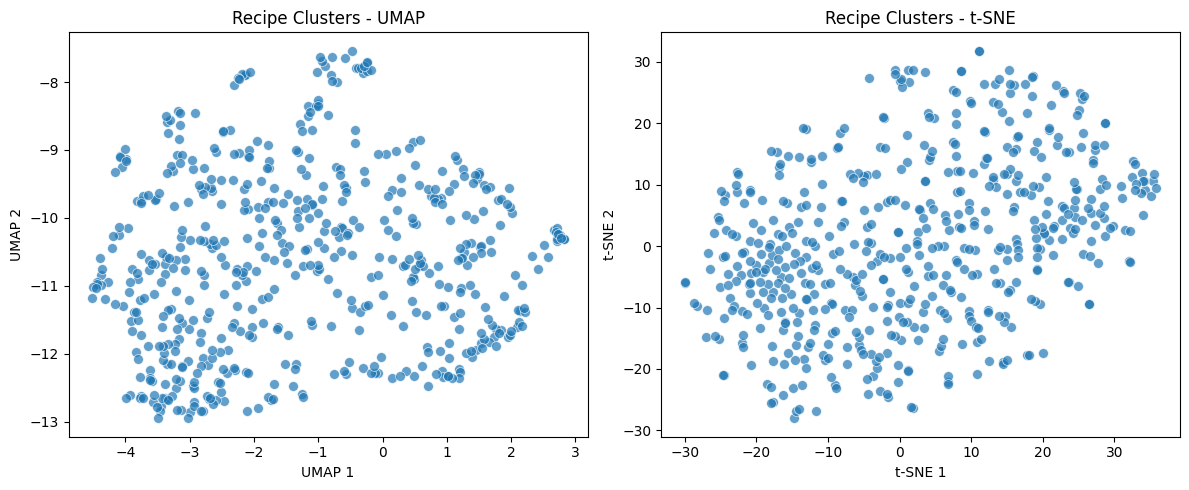

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import umap.umap_ as umap 

# -------------------------
# 1️⃣ Prepare the ingredient data
# -------------------------
# Assume df has a column 'normalized_ingredients' (list of strings per recipe)
processed_df['ingredients_str'] = processed_df['normalized_ingredients'].apply(lambda x: ' '.join(x))

# Convert to binary ingredient vectors
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(processed_df['ingredients_str'])

print(f"Ingredient matrix shape: {X.shape}")  # (recipes x unique ingredients)

# -------------------------
# 2️⃣ UMAP embedding
# -------------------------
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='jaccard', random_state=42)
embedding_umap = reducer.fit_transform(X.toarray())

processed_df['umap_x'] = embedding_umap[:,0]
processed_df['umap_y'] = embedding_umap[:,1]

# -------------------------
# 3️⃣ t-SNE embedding
# -------------------------
tsne = TSNE(n_components=2, metric='jaccard', perplexity=30, random_state=42)
embedding_tsne = tsne.fit_transform(X.toarray())

processed_df['tsne_x'] = embedding_tsne[:,0]
processed_df['tsne_y'] = embedding_tsne[:,1]

# -------------------------
# 4️⃣ Visualize
# -------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(x='umap_x', y='umap_y', data=processed_df, s=50, alpha=0.7)
plt.title('Recipe Clusters - UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.subplot(1,2,2)
sns.scatterplot(x='tsne_x', y='tsne_y', data=processed_df, s=50, alpha=0.7)
plt.title('Recipe Clusters - t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.show()


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine ingredients into a string per recipe
processed_df['ingredients_str'] = processed_df['normalized_ingredients'].apply(lambda x: ' '.join(x))

# Binary vectorization
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(processed_df['ingredients_str'])

print(f"TF-IDF matrix shape: {X_tfidf.shape}")   # (recipes x unique ingredients)


TF-IDF matrix shape: (555, 1323)


In [33]:
from sklearn.neighbors import NearestNeighbors

# Fit KNN using cosine similarity
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(X_tfidf)

# Find neighbors for all recipes
distances, indices = knn.kneighbors(X_tfidf)

# Store neighbors in the dataframe
processed_df['neighbor_indices'] = list(indices)
processed_df['neighbor_distances'] = list(distances)


In [35]:
recipe_idx = 0
print("Recipe:", processed_df.loc[recipe_idx, 'ingredients_str'])
print("\nClosest neighbors:")
for neighbor_idx, distance in zip(indices[recipe_idx], distances[recipe_idx]):
    print(f"- {processed_df.loc[neighbor_idx, 'ingredients_str']} (cosine distance: {distance:.2f})")


Recipe: salted butter garlic ginger jasmine rice hot water chicken broth concentrate packets green onion

Closest neighbors:
- salted butter garlic ginger jasmine rice hot water chicken broth concentrate packets green onion (cosine distance: 0.00)
- clarified butter or canola oil sweet onion jasmine rice cumin sea salt garlic low sodium chicken broth or water tomato sauce fully cooked carnitas frozen roasted corn black beans mexican blend cheese reduced guilt guacamole salsa (cosine distance: 0.72)
- coconut aminos rice vinegar crunchy chili onion garlic ginger agave (cosine distance: 0.74)
- canola oil yellow onion ginger garlic cayenne sea salt pepper tomato paste sweet potato low sodium vegetable broth creamy salted peanut butter shredded kale half salt peanuts (cosine distance: 0.77)
- onion premium peeled garlic jalape os chicken thighs salsa verde ground cumin jasmine rice black beans lime wedges and chopped cilantro (cosine distance: 0.78)


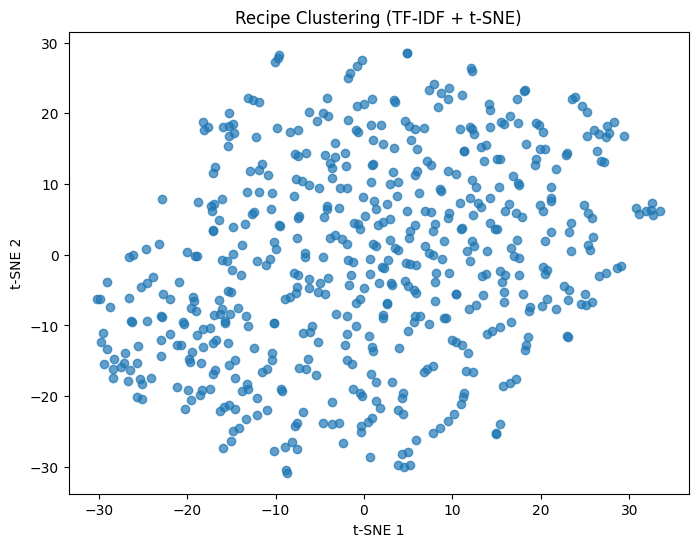

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, metric='cosine', random_state=42)
embedding = tsne.fit_transform(X_tfidf.toarray())

processed_df['tsne_x'] = embedding[:,0]
processed_df['tsne_y'] = embedding[:,1]

plt.figure(figsize=(8,6))
plt.scatter(processed_df['tsne_x'], processed_df['tsne_y'], alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Recipe Clustering (TF-IDF + t-SNE)')
plt.show()

In [44]:
from sklearn.cluster import KMeans

n_clusters = 8  # adjust depending on your dataset
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
processed_df['cluster'] = kmeans.fit_predict(X_tfidf)


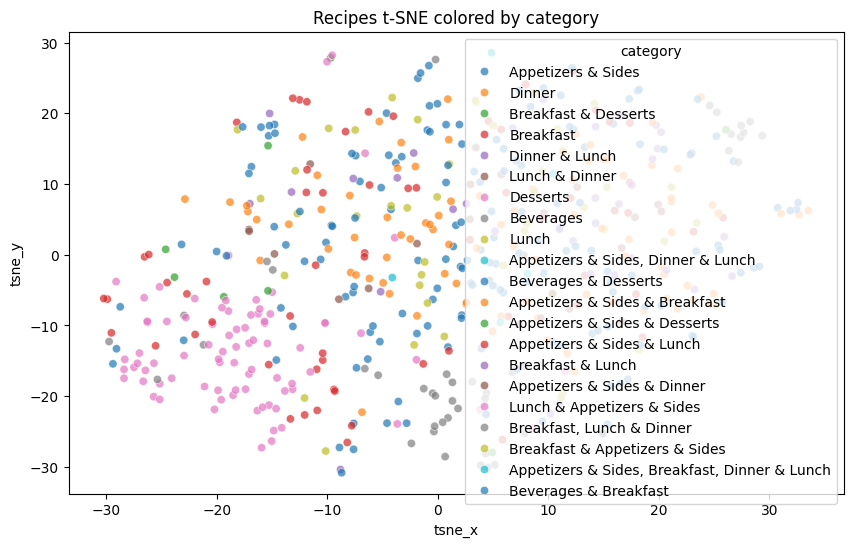

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(
    x='tsne_x', 
    y='tsne_y', 
    hue='category',       # or any column representing a grouping
    data=processed_df, 
    palette='tab10', 
    alpha=0.7
)
plt.title('Recipes t-SNE colored by category')
plt.show()


In [58]:
products_df

,category,product_name,price,unit,url
0,Bakery,Herbed Dinner Rolls,$3.49,/12 Oz,https://www.traderjoes.com/home/products/pdp/h...
1,Bakery,Pumpkin & Spice Brioche Style Liège Waffles,$4.49,/11.64 Oz,https://www.traderjoes.com/home/products/pdp/p...
2,Bakery,Glazed Pumpkin Pie Spice Donut Holes,$3.49,/6 Oz,https://www.traderjoes.com/home/products/pdp/g...
3,Bakery,Pumpkin Spice Mini Sheet Cake,$5.99,/18 Oz,https://www.traderjoes.com/home/products/pdp/p...
4,Bakery,Sliced Apple Cinnamon Sourdough Bread,$4.99,/17.63 Oz,https://www.traderjoes.com/home/products/pdp/s...
...,...,...,...,...,...
1244,Snacks & Sweets,Scandinavian Swimmers,$3.79,/14 Oz,https://www.traderjoes.com/home/products/pdp/s...
1245,Snacks & Sweets,Dark Chocolate Orange Sticks,$3.99,/10 Oz,https://www.traderjoes.com/home/products/pdp/d...
1246,Snacks & Sweets,Twisted Cookie Sticks,$2.29,/2.65 Oz,https://www.traderjoes.com/home/products/pdp/t...
1247,Snacks & Sweets,Plantain Chips,$1.99,/6 Oz,https://www.traderjoes.com/home/products/pdp/p...


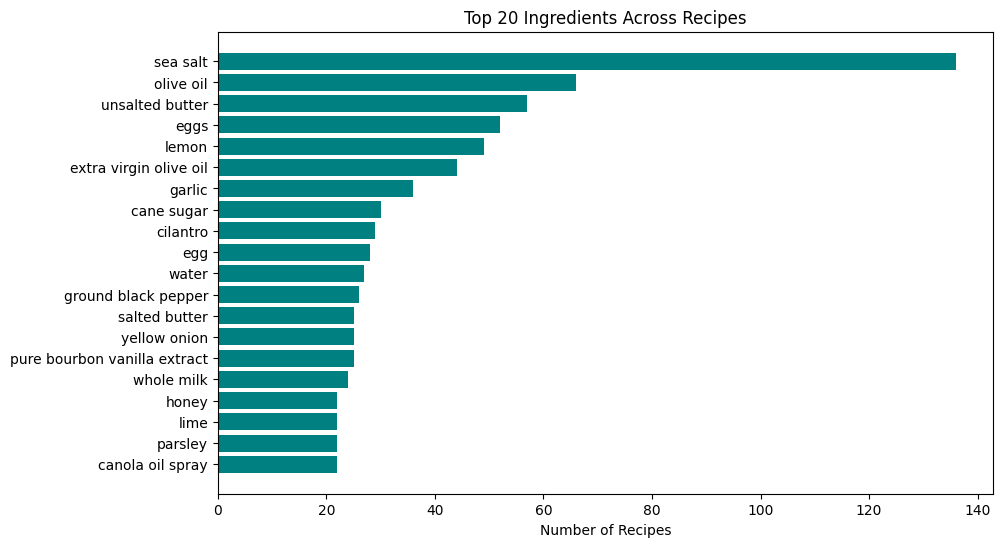

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the list of ingredients
all_ingredients = [ing for sublist in processed_df['normalized_ingredients'] for ing in sublist]

# Count frequency
ingredient_counts = Counter(all_ingredients)
top_20 = ingredient_counts.most_common(20)

# Convert to DataFrame for plotting
top_df = pd.DataFrame(top_20, columns=['ingredient', 'count'])

# Plot
plt.figure(figsize=(10,6))
plt.barh(top_df['ingredient'][::-1], top_df['count'][::-1], color='teal')
plt.xlabel('Number of Recipes')
plt.title('Top 20 Ingredients Across Recipes')
plt.show()


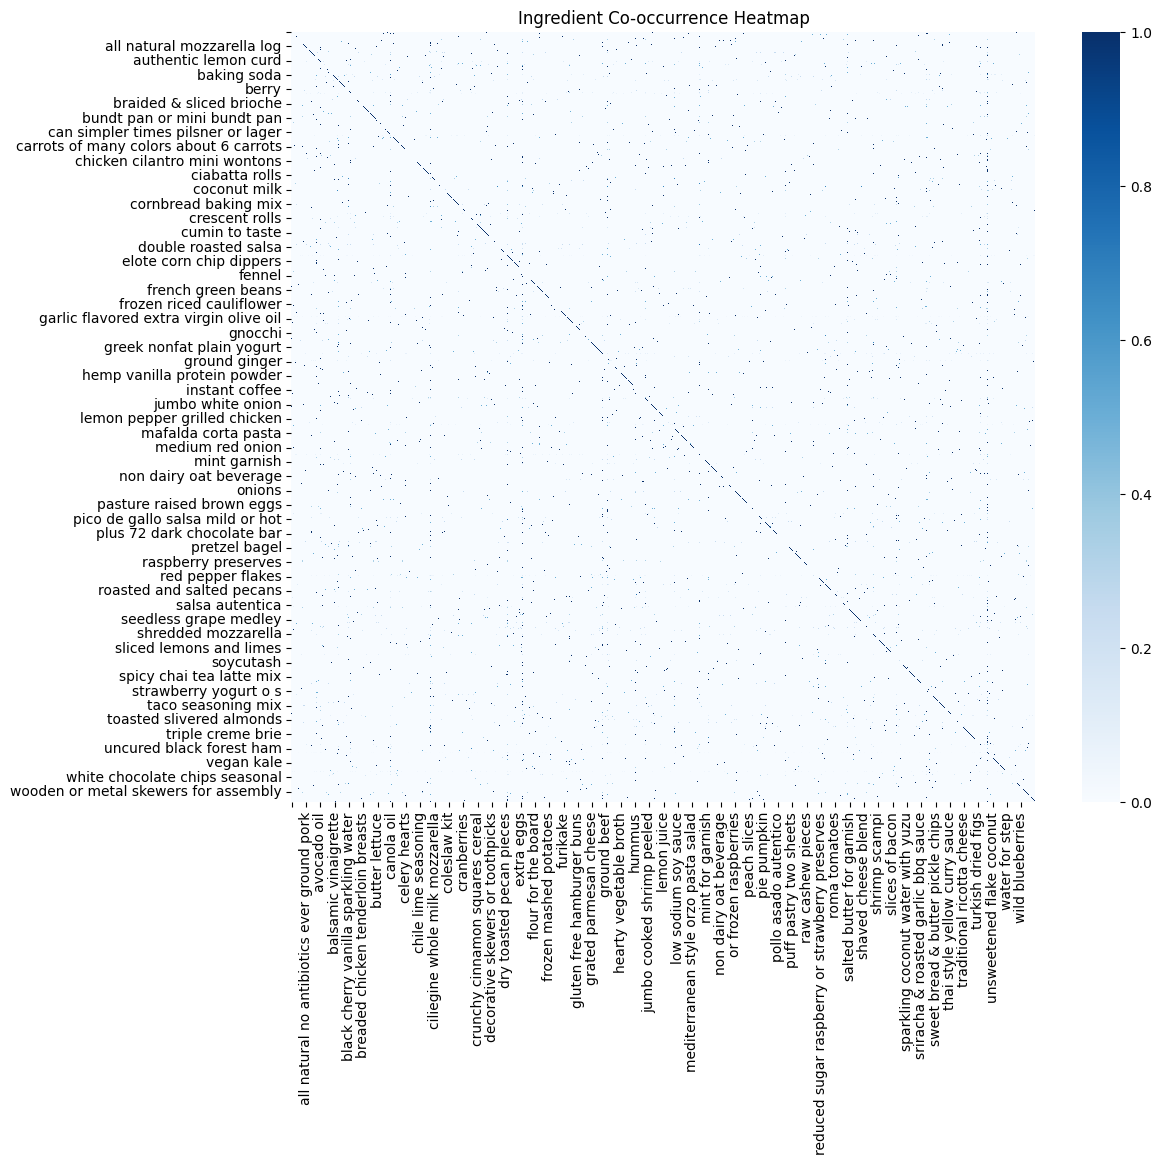

In [50]:
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

# Encode ingredients as binary matrix
mlb = MultiLabelBinarizer()
ingredient_matrix = mlb.fit_transform(processed_df['normalized_ingredients'])
ingredient_df = pd.DataFrame(ingredient_matrix, columns=mlb.classes_)

# Compute co-occurrence
co_occurrence = ingredient_df.T.dot(ingredient_df)
# Optional: normalize by diagonal to get Jaccard-like measure
co_occurrence_normalized = co_occurrence / co_occurrence.values.diagonal()[:,None]

# Plot
plt.figure(figsize=(12,10))
sns.heatmap(co_occurrence_normalized, cmap='Blues')
plt.title('Ingredient Co-occurrence Heatmap')
plt.show()


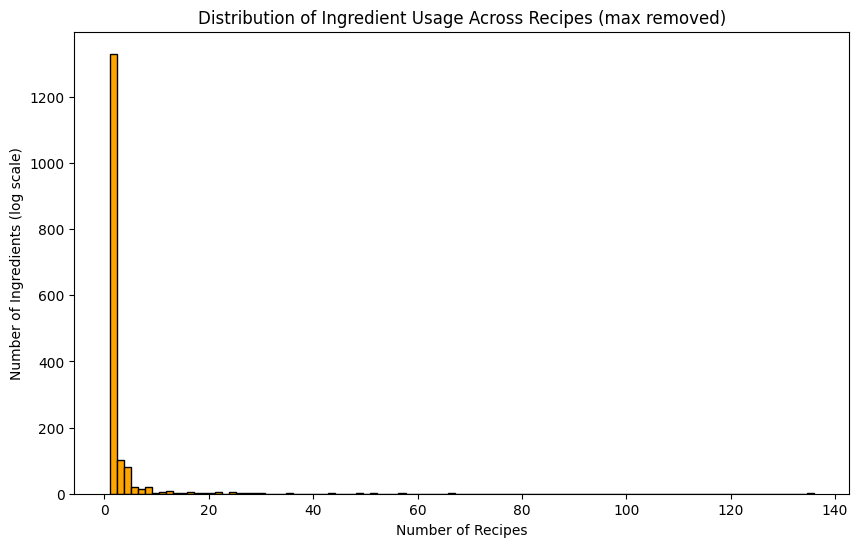

In [61]:
import matplotlib.pyplot as plt
from collections import Counter

# Flatten list of ingredients
all_ingredients = [ing for sublist in processed_df['normalized_ingredients'] for ing in sublist]

# Count frequency
ingredient_counts = Counter(all_ingredients)

# Remove the highest frequency
counts_filtered = [count for count in ingredient_counts.values()]# if count != max(ingredient_counts.values())]

plt.figure(figsize=(10,6))
plt.hist(counts_filtered, bins=100, color='orange', edgecolor='black')
plt.xlabel('Number of Recipes')
plt.ylabel('Number of Ingredients (log scale)')
plt.title('Distribution of Ingredient Usage Across Recipes (max removed)')
plt.show()


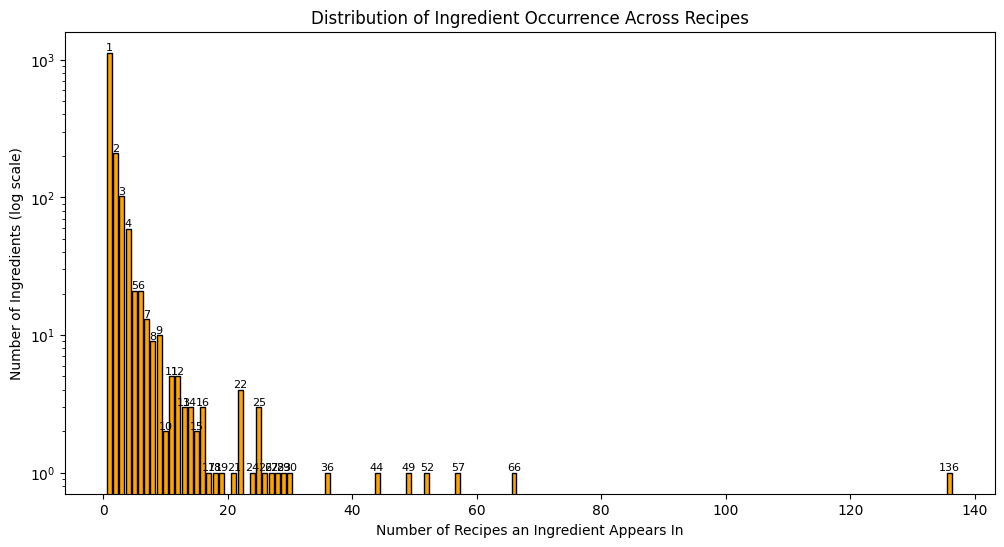

In [69]:
import matplotlib.pyplot as plt
from collections import Counter

# Flatten all ingredients
all_ingredients = [ing for sublist in processed_df['normalized_ingredients'] for ing in sublist]

# Count how many recipes each ingredient appears in
ingredient_counts = Counter(all_ingredients)

# Count how many ingredients appear in N recipes
freq_counts = Counter(ingredient_counts.values())

# Sort by number of recipes
x = sorted(freq_counts.keys())        # Number of recipes an ingredient appears in
y = [freq_counts[i] for i in x]      # Number of ingredients in that group

plt.figure(figsize=(12,6))
bars = plt.bar(x, y, color='orange', edgecolor='black', log=True)

# Add labels on top of bars showing the number of recipes (x value)
for xi, yi in zip(x, y):
    plt.text(xi, yi, str(xi), ha='center', va='bottom', fontsize=8)

plt.xlabel('Number of Recipes an Ingredient Appears In')
plt.ylabel('Number of Ingredients (log scale)')
plt.title('Distribution of Ingredient Occurrence Across Recipes')
plt.show()


In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Flatten all ingredients to count appearances
from collections import Counter
all_ingredients = [ing for sublist in processed_df['normalized_ingredients'] for ing in sublist]
ingredient_counts = Counter(all_ingredients)

# Keep only ingredients that appear in at least N recipes
min_recipe_count = 15
high_freq_ingredients = {ing for ing, count in ingredient_counts.items() if count >= min_recipe_count}

# Convert each recipe to a string of only high-frequency ingredients
processed_df['filtered_ingredients_str'] = processed_df['normalized_ingredients'].apply(
    lambda ings: ' '.join([ing for ing in ings if ing in high_freq_ingredients])
)

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(processed_df['filtered_ingredients_str'])
print(f"Shape of filtered TF-IDF matrix: {X_tfidf.shape}")


Shape of filtered TF-IDF matrix: (555, 41)


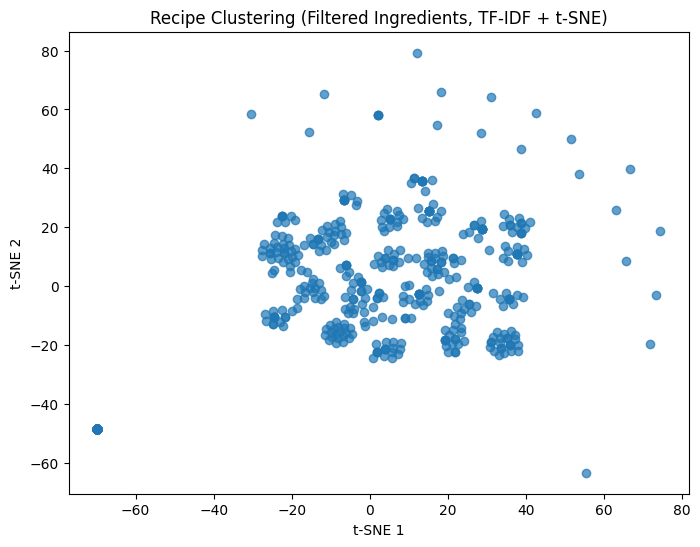

In [81]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, metric='cosine', random_state=42)
embedding = tsne.fit_transform(X_tfidf.toarray())

processed_df['tsne_x'] = embedding[:,0]
processed_df['tsne_y'] = embedding[:,1]

plt.figure(figsize=(8,6))
plt.scatter(processed_df['tsne_x'], processed_df['tsne_y'], alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Recipe Clustering (Filtered Ingredients, TF-IDF + t-SNE)')
plt.show()


In [82]:
from sklearn.cluster import KMeans, DBSCAN

# Example: KMeans
num_clusters = 8  # choose based on domain knowledge or elbow method
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_tfidf)

processed_df['cluster'] = cluster_labels


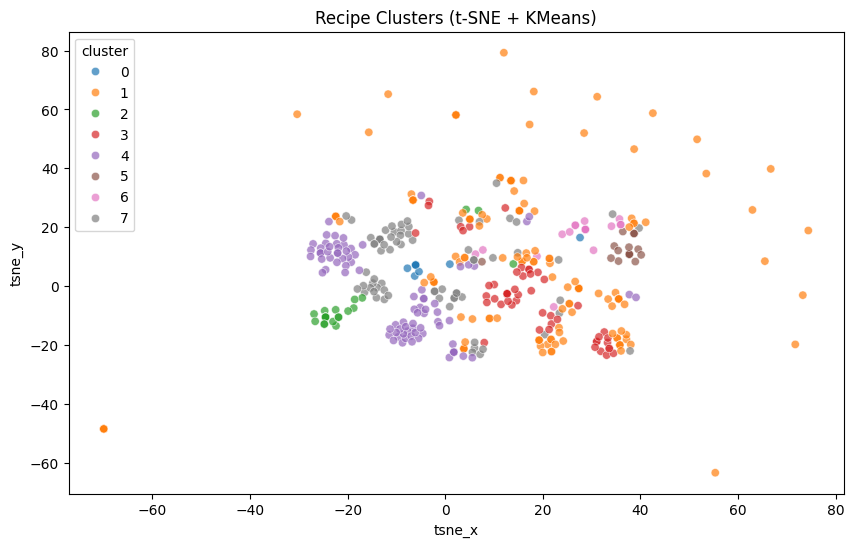

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, metric='cosine', random_state=42)
embedding = tsne.fit_transform(X_tfidf.toarray())

processed_df['tsne_x'] = embedding[:,0]
processed_df['tsne_y'] = embedding[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(
    x='tsne_x', y='tsne_y',
    hue='cluster',
    palette='tab10',
    data=processed_df,
    legend='full',
    alpha=0.7
)
plt.title('Recipe Clusters (t-SNE + KMeans)')
plt.show()


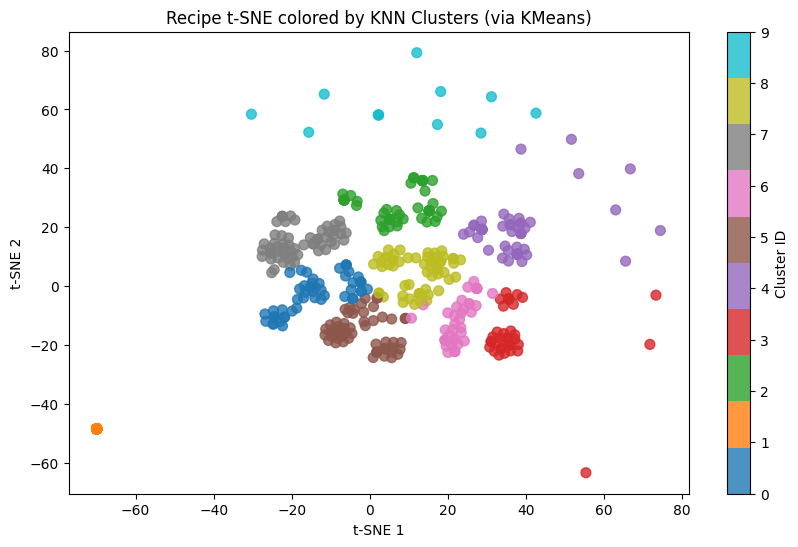

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

# 1️⃣ t-SNE coordinates
tsne_coords = processed_df[['tsne_x', 'tsne_y']].values

# 2️⃣ Use KNN distances as feature for clustering
k = 5
knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
knn.fit(tsne_coords)
distances, indices = knn.kneighbors(tsne_coords)

# 3️⃣ Option 1: cluster based on t-SNE using KMeans
# This will group recipes roughly according to proximity in t-SNE space
n_clusters = 10  # adjust for how many clusters you want
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
processed_df['knn_cluster'] = kmeans.fit_predict(tsne_coords)

# 4️⃣ Plot, colored by cluster
plt.figure(figsize=(10,6))
plt.scatter(
    processed_df['tsne_x'],
    processed_df['tsne_y'],
    c=processed_df['knn_cluster'],
    cmap='tab10',  # choose a qualitative colormap
    s=50,
    alpha=0.8
)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Recipe t-SNE colored by KNN Clusters (via KMeans)')
plt.colorbar(label='Cluster ID')
plt.show()


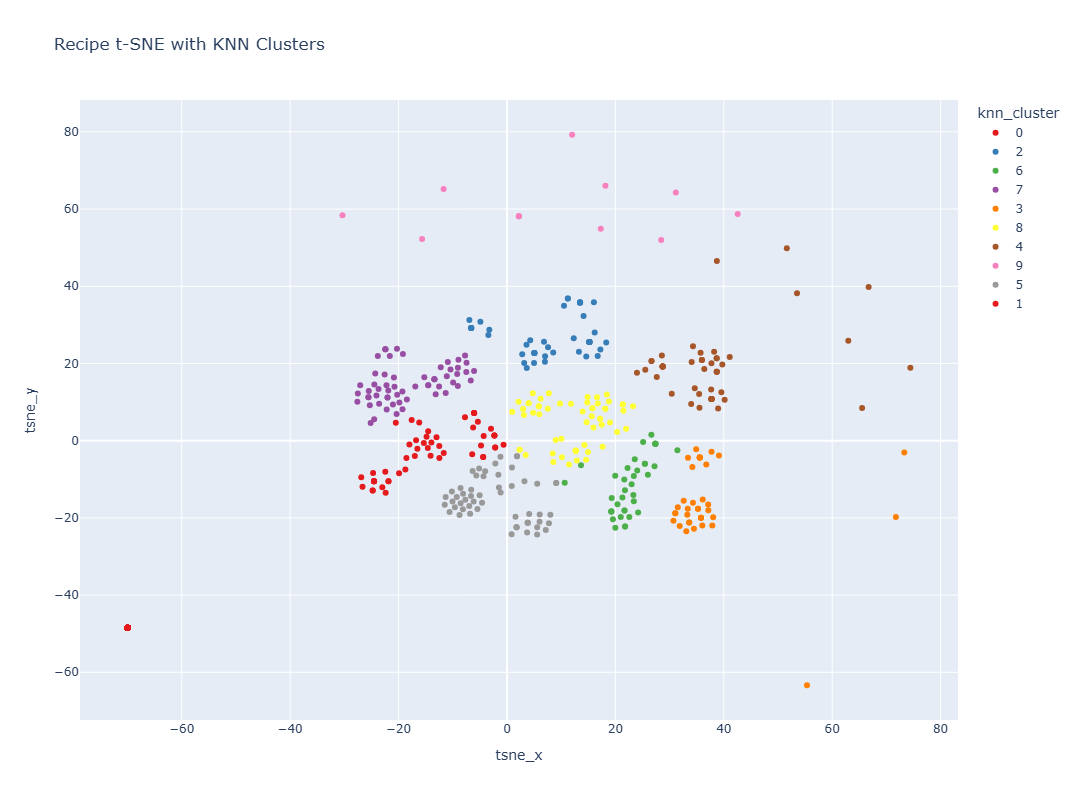

In [94]:
import plotly.express as px

# Ensure knn_cluster is treated as categorical
processed_df['knn_cluster'] = processed_df['knn_cluster'].astype(str)

# Optional: create hover text
processed_df['hover_text'] = processed_df.apply(
    lambda row: f"<b>{row['title']}</b><br>Ingredients:<br>" + "<br>".join(row['normalized_ingredients']),
    axis=1
)

# Use a discrete color palette similar to matplotlib 'tab10'
color_palette = px.colors.qualitative.Set1  # Set1 is 9 colors; for 10 clusters, Plotly will cycle colors

fig = px.scatter(
    processed_df,
    x='tsne_x',
    y='tsne_y',
    color='knn_cluster',              # discrete clusters
    hover_data={'hover_text': True, 'tsne_x': False, 'tsne_y': False},
    color_discrete_sequence=color_palette,
    title='Recipe t-SNE with KNN Clusters',
    width=800,   # figure width
    height=800    # figure height
)

# Show hover text nicely
fig.update_traces(hovertemplate='%{customdata[0]}')

fig.show()


dbscan_cluster
 2    167
 7    136
 0     95
 1     41
 3     31
 8     24
-1     19
 4     17
 5     13
 6      9
 9      3
Name: count, dtype: int64


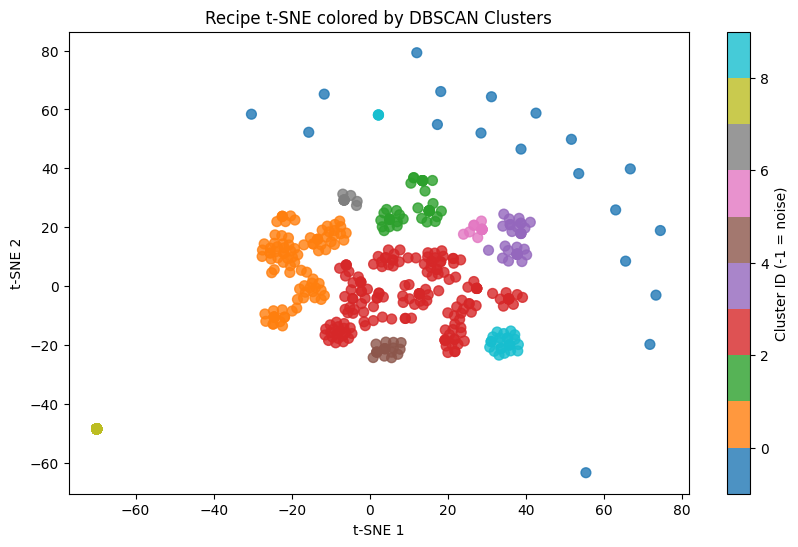

In [96]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# -------------------------
# 1️⃣ DBSCAN clustering
# -------------------------
# eps = max distance between neighbors to be considered in the same cluster
# min_samples = minimum points required to form a dense region
dbscan = DBSCAN(eps=5, min_samples=3, metric='euclidean')  
processed_df['dbscan_cluster'] = dbscan.fit_predict(tsne_coords)

# DBSCAN labels: -1 is noise
print(processed_df['dbscan_cluster'].value_counts())

# -------------------------
# 2️⃣ Plotting
# -------------------------
plt.figure(figsize=(10,6))
plt.scatter(
    processed_df['tsne_x'],
    processed_df['tsne_y'],
    c=processed_df['dbscan_cluster'],
    cmap='tab10',  # discrete colors for clusters
    s=50,
    alpha=0.8
)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Recipe t-SNE colored by DBSCAN Clusters')
plt.colorbar(label='Cluster ID (-1 = noise)')
plt.show()
